# Tiling seals (not ceiling tiles)

Given a massive TIFF, extract tiles around some specific (x, y) locations. These are seals.

Also extract some tiles that are not close to those (x, y) locations, and are also not too white (mask zone). These are not seals.

In [41]:
import os
import struct

import numpy as np
import pandas as pd
import scipy.spatial

%matplotlib inline
import matplotlib.pyplot as plt

Install gdal with `conda install -c conda-forge gdal`

In [42]:
import gdal

## Dataframe

We'll just read one image for now.

In [60]:
xls = '/home/matt/Downloads/seals/LingaHolm_SampleFiles_20180906/Linga Holm_ORKlh_2016_3&4_20180906.xlsx'
df = pd.read_excel(xls, sheet_name=1)

In [61]:
df.image_file.unique()

array(['StitchMICE_ORKlh16_3_1104_CP_FINAL.tif',
       'StitchMICE_ORKlh16_4_1117_CP_FINAL.tif'], dtype=object)

In [62]:
input_fname = df.image_file.unique()[1]
df = df[df.image_file == fname]

In [63]:
df.head()

,image_file,class,x,y,date_counted
3041,StitchMICE_ORKlh16_4_1117_CP_FINAL.tif,whitecoat,35994.974282,58410.725029,2018-05-28
3042,StitchMICE_ORKlh16_4_1117_CP_FINAL.tif,whitecoat,36698.974282,58376.725029,2018-05-28
3043,StitchMICE_ORKlh16_4_1117_CP_FINAL.tif,whitecoat,36676.974282,58398.725029,2018-05-28
3044,StitchMICE_ORKlh16_4_1117_CP_FINAL.tif,whitecoat,37321.374282,57937.725029,2018-05-28
3045,StitchMICE_ORKlh16_4_1117_CP_FINAL.tif,whitecoat,38404.574282,57051.325029,2018-05-28


In [64]:
df['class'].unique()

array(['whitecoat', 'moulted', 'dead', 'double'], dtype=object)

In [65]:
df.describe()

,x,y
count,3127.000000,3127.000000
mean,27056.283269,25308.597334
std,11586.787093,13363.805393
min,1026.174282,468.225029
25%,18870.174282,15574.625029
50%,29902.374282,24776.625029
75%,36478.174282,32634.525029
max,44740.374282,58526.725029


## Make +ve image tiles

We can't read these images (easily anyway) into a PIL image or NumPy array. So we'll use GDAL to make the subiages, because it can work out of core (i.e. without reading the image into memory).

In [66]:
input_dir = '/home/matt/Downloads/seals/LingaHolm_SampleFiles_20180906'

output_dir = '/home/matt/Downloads/seals/out_pos'

In [67]:
fname = os.path.join(input_dir, input_fname)

In [68]:
ds = gdal.Open(fname)
band = ds.GetRasterBand(1)
x_size = band.XSize
y_size = band.YSize

In [69]:
# Use globals for now. A bit lazy...
X_TILE_SIZE = 80
Y_TILE_SIZE = 80

Define a function that, when applied to all the rows in a DataFrame, will use the x and y values to extract subimages. Note that the function returns None, and has the side-effect of running a GDAL command on the input file. 

In [70]:
def make_tile(x, y, fname, output_dir, output_stem):
    """
    To be used by df.apply(). Uses globals (should probably curry instead.)
    """
    # Transform to image coordinates.
    x, y = x - X_TILE_SIZE/2, y_size - y - Y_TILE_SIZE/2
    
    # Form output file name.
    outfile = os.path.join(output_dir, f'{output_stem}.tif')
    
    # Do operation and save file.
    com_string = f"gdal_translate -of GTIFF -srcwin {x}, {y}, {X_TILE_SIZE}, {Y_TILE_SIZE} {fname} {outfile}"
    os.system(com_string)
    
    # No need to return anything but we can send back filename.
    return outfile

In [71]:
def mapper(row):
    return make_tile(row.x, row.y, fname, output_dir, row.name)

Uncomment the next cell to perform the tiling. Note: this part takes a few minutes and creates about 6000 files.

In [72]:
df.apply(mapper, axis=1)

3041    /home/matt/Downloads/seals/out_pos/3041.tif
3042    /home/matt/Downloads/seals/out_pos/3042.tif
3043    /home/matt/Downloads/seals/out_pos/3043.tif
3044    /home/matt/Downloads/seals/out_pos/3044.tif
3045    /home/matt/Downloads/seals/out_pos/3045.tif
3046    /home/matt/Downloads/seals/out_pos/3046.tif
3047    /home/matt/Downloads/seals/out_pos/3047.tif
3048    /home/matt/Downloads/seals/out_pos/3048.tif
3049    /home/matt/Downloads/seals/out_pos/3049.tif
3050    /home/matt/Downloads/seals/out_pos/3050.tif
3051    /home/matt/Downloads/seals/out_pos/3051.tif
3052    /home/matt/Downloads/seals/out_pos/3052.tif
3053    /home/matt/Downloads/seals/out_pos/3053.tif
3054    /home/matt/Downloads/seals/out_pos/3054.tif
3055    /home/matt/Downloads/seals/out_pos/3055.tif
3056    /home/matt/Downloads/seals/out_pos/3056.tif
3057    /home/matt/Downloads/seals/out_pos/3057.tif
3058    /home/matt/Downloads/seals/out_pos/3058.tif
3059    /home/matt/Downloads/seals/out_pos/3059.tif
3060    /hom

### TODO

- Make the images into JPEGs.
- Make the images monochrome (?).
- Rotate and/or flip the images.
- Compute some new attributes of the images.

## Make -ve (non-seal) tiles

Strategy: 

1. Select a point a random.
1. If the point is too close to a known seal, reject it.
1. If the point contains too many white pixels, reject it.
1. Continue until we have as many points as we want (e.g. 8000).

We'll work on the `band` object directly this time, because we need to inspect the pixels of each selected point.

Let's try extracting a single tile:

In [73]:
scan = band.ReadRaster(35000, 35040, 80, 80, buf_type=gdal.GDT_Float32)
data = struct.unpack('f' * 80*80, scan)

In [74]:
data = np.array(data).reshape(80, 80)

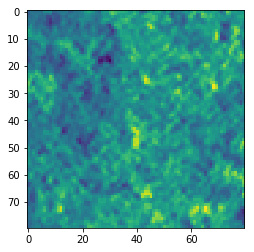

In [75]:
plt.imshow(data)

In [76]:
np.max(data)

103.0

Compare with some of the mask:

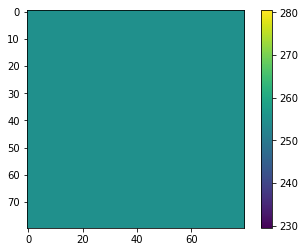

In [77]:
scan = band.ReadRaster(2000, 2000, 80, 80, buf_type=gdal.GDT_Float32)
data = struct.unpack('f' * 80*80, scan)
data = np.array(data).reshape(80, 80)
im = plt.imshow(data)
plt.colorbar(im)

In [78]:
data

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [79]:
data[data > 250].size / data.size

1.0

We'll implement the alogirithm described above: pick random points, check that they aren't too close to known seals, check don't have too many white pixels, then store them if they seem OK.

In [83]:
# Make the k-d tree.
tree = scipy.spatial.KDTree(np.array([df.x, df.y]).T)

negs = []
while len(negs) < 7000:

    # Make random coordinates.
    x, y = np.random.randint(0, x_size), np.random.randint(0, y_size)
    x_, y_ = x - X_TILE_SIZE/2, y_size - y - Y_TILE_SIZE/2
    
    # Find distance to nearest, reject if too close.
    dist, _ =  tree.query([x, y])
    if dist < np.sqrt(2*80**2):
        continue
    
    # Read the data for this tile.
    scan = band.ReadRaster(x_, y_, X_TILE_SIZE, Y_TILE_SIZE, buf_type=gdal.GDT_Float32)
    try:
        # Sometimes this fails, not sure why. Maybe at the edges?
        data = struct.unpack('f' * X_TILE_SIZE * Y_TILE_SIZE, scan)
    except:
        continue

    # Make an array of the data. These are 8-bit ints. (Why?)
    a = np.array(data).reshape(X_TILE_SIZE, Y_TILE_SIZE)
    
    # If more than 5% of image is ~white, reject.
    if a[a > 250].size / a.size > 0.05:
        continue
    
    # If the tile survived, add it.
    negs.append((x, y))

Instead of doing this next thing, we could just save the array `a`, above, as a JPEG, via PIL `Image`. We did this first though, so let's go with it :)

In [85]:
output_dir='/home/matt/Downloads/seals/out_neg'
for i, (x, y) in enumerate(negs):
    out = make_tile(x, y, fname, output_dir, output_stem=i)
    # print(out)